# Pipeline draft

In [1]:
import torch
import numpy as np
from omegaconf import OmegaConf
from functools import partial
import gymnasium as gym
import matplotlib.pyplot as plt

import time

import bbrl_utils
from bbrl_utils.notebook import setup_tensorboard
from bbrl.stats import WelchTTest
from bbrl.agents import Agent, Agents, TemporalAgent
from bbrl.agents.gymnasium import ParallelGymAgent, make_env
from bbrl.workspace import Workspace
from bbrl.utils.replay_buffer import ReplayBuffer

import bbrl_gymnasium

from pmind.algorithms import DQN, DDPG, TD3, OfflineTD3
from pmind.losses import dqn_compute_critic_loss, ddqn_compute_critic_loss
from pmind.training import (
    run_dqn, 
    run_ddpg, 
    run_td3, 
    run_td3_offline,
    load_trained_agents,
)
from pmind.replay import (
    collect_policy_transitions, 
    collect_uniform_transitions, 
    mix_transitions, 
    test_rb_compositions,
)

from pmind.visualization import (
    plot_perf_vs_rb_composition_from_dict
)

from pmind.config.loader import load_config

bbrl_utils.setup()

cfg = load_config("bbrl_example")

%load_ext autoreload
%autoreload 2

/Users/vlad/Documents/University/Master-MIND/projet-mind/.venv/lib/python3.10/site-packages/bbrl_utils/notebook.py:46: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm  # noqa: F401
Using Python 3.10.18 environment at: /Users/vlad/Documents/University/Master-MIND/projet-mind/.venv


In [ ]:
# setup_tensorboard("./outputs/tblogs")

# Obtain transitions

In [2]:
ENV_NAME = (
    "CartPoleContinuous-v1",
    "Pendulum-v1",
    "MountainCarContinuous-v0",
    "LunarLanderContinuous-v3",
)[0]
REWARDS = [500] # CartPole: [113, 225, 375, 500]
BUFFER_SIZE = 100_000
RETRAIN_EXPLOIT = False

## Best policy

Get the best policy and get transitions with it

In [3]:
if RETRAIN_EXPLOIT:
    cfg_td3_exploit = OmegaConf.create(cfg.td3)
    cfg_td3_exploit.gym_env.env_name = ENV_NAME

    # accelerate for the sake of test:
    cfg_td3_exploit.algorithm.max_epochs = 11_000
    cfg_td3_exploit.algorithm.learning_starts = 1000

    # TODO: plot_agents() doesn't work with Lunar Lander
    cfg_td3_exploit.plot_agents=False 

    # Playing with parameters for mountain car / pendulum:
    # cfg_td3_exploit.algorithm.action_noise = 0.1
    # cfg_td3_exploit.algorithm.discount_factor = 0.98
    # cfg_td3_exploit.algorithm.learning_starts = 10_000
    # cfg_td3_exploit.actor_optimizer.lr = 1e-3
    # cfg_td3_exploit.critic_optimizer.lr = 1e-3
    # cfg_td3_exploit.algorithm.tau_target = 0.005
    # cfg_td3_exploit.algorithm.learning_starts = 2_000
    # cfg_td3_exploit.algorithm.architecture.critic_hidden_size = [128,128]
    # cfg_td3_exploit.algorithm.architecture.actor_hidden_size = [128,128]
    

    td3 = TD3(cfg_td3_exploit)
    trained_agents = run_td3(td3, save_model_at_rewards=REWARDS)
    td3.visualize_best()
else:
    trained_agents = load_trained_agents(ENV_NAME, REWARDS)

In [4]:
rb_exploit_by_level = {}
for k, policy_agent in trained_agents.items():
    # TODO: save rbs!
    rb_exploit_by_level[k] = collect_policy_transitions(policy_agent, ENV_NAME, BUFFER_SIZE)

Matplotlib backend: inline


## Uniform exploration

In [12]:
rb_unif = collect_uniform_transitions(ENV_NAME, buffer_size=BUFFER_SIZE)

100%|██████████| 100000/100000 [00:10<00:00, 9142.12it/s]

300356 of proposed states were rejected


# Offline learning on mixed replay buffer

In [9]:
PROPORTIONS = np.linspace(0,1,10)
SEEDS = [1] # [0,1,2,3,4]

In [10]:
cfg_td3_offline = OmegaConf.create(cfg.td3)
cfg_td3_offline.gym_env.env_name = ENV_NAME

# to get 100K training steps:
cfg_td3_offline.algorithm.n_steps = 100
cfg_td3_offline.algorithm.max_epochs = 1000 # TODO: epochs don't actually make sense for offline

# learning starts immediately for offline:
cfg_td3_offline.algorithm.learning_starts = None

# there is no exploration in offline learning 
cfg_td3_offline.algorithm.action_noise = None
cfg_td3_offline.algorithm.target_policy_noise = None

cfg_td3_offline.plot_agents=False # TODO: plot_agents() doesn't work with Lunar Lander

In [13]:
# ACCELERATE FOR THE TEST: 
# cfg_td3_offline.algorithm.n_steps = 10
# cfg_td3_offline.algorithm.max_epochs = 10
# cfg_td3_offline.algorithm.eval_interval = 2
# cfg_td3_offline.algorithm.nb_evals= 5


performances = {}
for k, rb_exploit in rb_exploit_by_level.items():
    # TODO: find a way to temporarily silence tqdm
    performances[k] = test_rb_compositions(
        rb_unif=rb_unif,
        rb_exploit=rb_exploit,
        buffer_size=BUFFER_SIZE,
        proportions= PROPORTIONS,
        agent_constructor=OfflineTD3,
        cfg=cfg_td3_offline,
        offline_run=run_td3_offline,
        seeds=SEEDS # TODO: make buffer mixing take this seed as well
    ) 

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

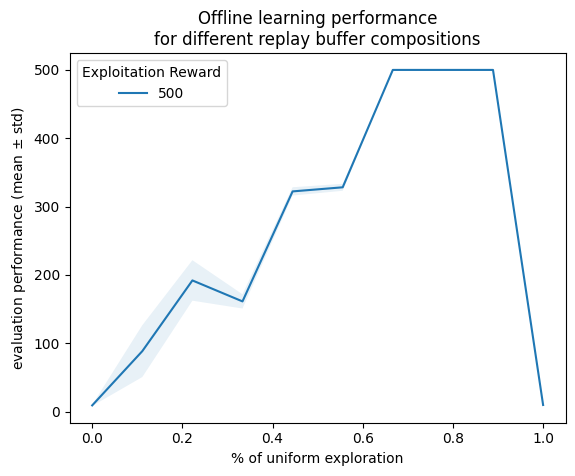

In [14]:
plot_perf_vs_rb_composition_from_dict(
    PROPORTIONS, 
    performances,
    last_n=1, # NOTE: depends on evaluation interval
    legend_title="Exploitation Reward",
    fig_name=f"{ENV_NAME}-offline-diff-best-policies-{int(time.time())}.pdf")